# CountMatch Matcher Development
## Part 3: Rewriting a Sensible Prototype Matcher

This notebook investigates why our prototype in Part 1 produces a much noisier ground truth vs. predictions plot, and much worse mean absolute error, for 2011.

In [1]:
%matplotlib inline
import sys
sys.path.append('../')
import importlib
import matplotlib.pyplot as plt
import numpy as np
import knowyourdata as kyd

import pandas as pd
from traffic_prophet import cfg
import pathlib, os
import configparser

from traffic_prophet import connection
from traffic_prophet.countmatch import reader
from traffic_prophet.countmatch import growthfactor as gf
from traffic_prophet.countmatch import neighbour

defaultcolours = plt.rcParams['axes.prop_cycle'].by_key()['color']

filepath = pathlib.Path.home().joinpath('.charlesconfig')
if os.path.isfile(filepath):
    vol_conn = connection.Connection(filepath, 'POSTGRES',
                                     'czhu.btp_centreline_daily_counts')
    ll_conn = connection.Connection(filepath, 'POSTGRES',
                                    'czhu.btp_centreline_lonlat')
    config = configparser.RawConfigParser()
    config.read(filepath.as_posix())
    MAPBOX_TOKEN = config['MAPBOX']['token']
    PLOTLY_USER = config['PLOTLY']['user']
    PLOTLY_KEY = config['PLOTLY']['key']
else:
    filepath = pathlib.Path.home().joinpath('cf.txt')
    vol_conn = connection.Connection(filepath, 'localpg',
                                     'prj_vol.btp_centreline_daily_counts')
    ll_conn = connection.Connection(filepath, 'localpg',
                                    'gis.btp_centreline_lonlat')
    config = configparser.RawConfigParser()
    config.read(filepath.as_posix())
    MAPBOX_TOKEN = config['mapbox']['token']
    PLOTLY_USER = config['plotly']['user']
    PLOTLY_KEY = config['plotly']['apikey']

In [2]:
rdr = reader.Reader(vol_conn)
%time rdr.read()

CPU times: user 1min 34s, sys: 781 ms, total: 1min 35s
Wall time: 1min 36s


In [3]:
gf.get_growth_factors(rdr)

In [4]:
ptc_ids = np.unique(np.abs(list(rdr.ptcs.keys())))
nb = neighbour.NeighbourLonLatEuclidean(ll_conn, 20, ptc_ids)
%time nb.find_neighbours()

CPU times: user 16.5 s, sys: 76.5 ms, total: 16.6 s
Wall time: 16.5 s


We won't worry about growth factors just yet, let's just get the MSE matcher working first.

## `D_ijd` Calculator

Let's calculate a day-of-week to AADT, just like the DoM factor.

In [5]:
# Sandbox first:

myptc = next(iter(rdr.ptcs.values()))
myptc.centreline_id

8540609

In [6]:
myptc.data['Daily Count'].loc[2015].head(30)

,Date,Daily Count
Day of Year,,
1,2015-01-01,135.0
2,2015-01-02,311.0
3,2015-01-03,161.0
4,2015-01-04,135.0
5,2015-01-05,257.0
6,2015-01-06,322.0
7,2015-01-07,221.0
8,2015-01-08,284.0
9,2015-01-09,247.0


In [7]:
myptc.data['DoMADT'].loc[2015]

Day of Week,0,1,2,3,4,5,6
Month,,,,,,,
1,345.00,331.000000,407.25,308.75,335.20,169.80,96.75
2,42.00,98.500000,107.00,130.00,98.25,37.00,53.50
3,554.20,460.800000,244.00,392.50,299.00,200.75,266.80
4,872.00,666.333333,1076.80,1040.80,557.00,613.25,439.75
5,1666.00,2166.500000,2120.75,2297.00,1977.40,1208.40,1201.00
6,1866.40,2014.600000,2398.00,2339.25,1853.75,1229.50,959.25
7,2411.50,2029.250000,2240.00,2393.60,1944.60,1337.25,1431.00
8,1736.20,1946.250000,2207.00,2035.50,1828.00,1333.20,1366.20
9,1735.25,1941.800000,2192.40,2409.25,2079.75,976.75,1101.50


In [8]:
doyadt = []
for year in myptc.data['AADT'].index:
    _ctable = myptc.data['AADT'].at[year, 'AADT'] / myptc.data['DoMADT'].loc[year]
    _ctable.index = pd.MultiIndex.from_product(
        [[year, ], _ctable.index],
        names=['Year', _ctable.index.name])
    doyadt.append(_ctable)

In [9]:
doyadt = pd.concat(doyadt)
doyadt.loc[2017]

Day of Week,0,1,2,3,4,5,6
Month,,,,,,,
1,2.401763,2.452139,2.159893,2.204459,2.346318,4.490803,5.225309
2,2.381592,2.224742,2.130840,1.943355,2.723232,4.112932,6.219438
3,1.918468,1.674232,1.702524,1.679127,2.442626,5.630014,4.915219
4,0.816292,0.899626,0.819203,1.168088,0.933253,1.588552,1.753470
5,0.759605,0.594781,0.556455,0.787919,1.166605,1.152268,1.227054
6,0.601872,0.678796,0.467735,0.597318,0.727604,0.779982,1.042690
7,0.638139,0.485890,0.488802,0.652755,0.623858,0.894349,0.934214
8,0.642710,0.569196,0.521250,0.609054,0.713923,0.885864,0.843417
9,0.592175,0.637241,0.479901,0.508308,0.606849,0.965308,1.021818


In [10]:
doyadt.loc[2015]

Day of Week,0,1,2,3,4,5,6
Month,,,,,,,
1,3.336559,3.477683,2.826551,3.728301,3.434108,6.779228,11.897808
2,27.407450,11.686425,10.758065,8.854715,11.716162,31.111160,21.516129
3,2.077071,2.498075,4.717676,2.932772,3.849876,5.734062,4.314516
4,1.320084,1.727533,1.069013,1.105989,2.066630,1.877070,2.617653
5,0.690944,0.531324,0.542786,0.501138,0.582135,0.952593,0.958462
6,0.616756,0.571385,0.480030,0.492086,0.620964,0.936245,1.200013
7,0.477343,0.567260,0.513890,0.480913,0.591954,0.860806,0.804412
8,0.663007,0.591452,0.521574,0.565519,0.629712,0.863421,0.842565
9,0.663370,0.592807,0.525047,0.477789,0.553486,1.178513,1.045041


/home/cczhu/pythonenv/ml3/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


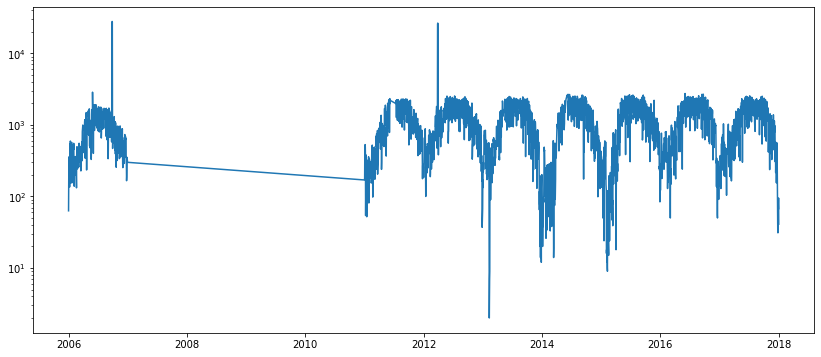

In [11]:
fig, ax = plt.subplots(figsize=(14, 6))
ax.semilogy(myptc.data['Daily Count'].loc[:, 'Date'],
            myptc.data['Daily Count'].loc[:, 'Daily Count'])

We need to install some kind of anomaly detector for PTCs - obviously something terrible is happening in 2014 and 2015.

In [12]:
myptc.data['AADT']

,AADT
Year,
2006,1062.784683
2011,1076.228148
2012,1513.753560
2013,1100.390389
2014,1107.003235
2015,1151.112911
2016,1214.887862
2017,1148.522887


In [13]:
# Get ratio between AADT and daily count
doyr = myptc.data['AADT'].copy()
doyr['DoYADT'] = np.empty(doyr.shape[0])
for year in doyr.index.values:
    # The mean utterly fails in the presence of outliers.
    doyr.loc[year, 'DoYADT'] = (
        myptc.data['AADT'].loc[year, 'AADT'] /
        myptc.data['Daily Count'].loc[year, 'Daily Count']).median()

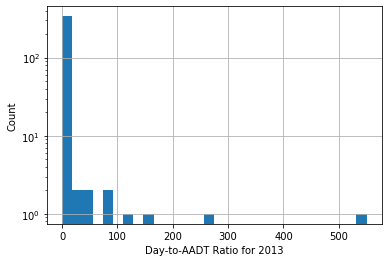

In [14]:
fig, ax = plt.subplots(figsize=(6, 4))
(myptc.data['AADT'].loc[2013, 'AADT'] /
 myptc.data['Daily Count'].loc[2013, 'Daily Count']).hist(ax=ax, bins=30, log=True)
ax.set_xlabel('Day-to-AADT Ratio for 2013')
ax.set_ylabel('Count');

### Functionalize `D_ijd` calculator

In [15]:
def get_Dijd(ptc):
    # Get ratio between daily count and AADT, grouping by month and day of week
    doyadt = []
    for year in ptc.data['AADT'].index:
        _ctable = ptc.data['AADT'].at[year, 'AADT'] / ptc.data['DoMADT'].loc[year]
        _ctable.index = pd.MultiIndex.from_product(
            [[year, ], _ctable.index],
            names=['Year', _ctable.index.name])
        doyadt.append(_ctable)
    ptc.data['D_ijd'] = pd.concat(doyadt)

    # Get ratio between AADT and daily count
    doyr = pd.DataFrame(
        {'D_i': np.empty(ptc.data['AADT'].shape[0])},
        index=ptc.data['AADT'].index)
    for year in doyr.index.values:
        # The mean utterly fails in the presence of outliers,
        # so use the **median** (in contravention to TEPs and Bagheri)
        doyr.loc[year, 'D_i'] = (
            ptc.data['AADT'].loc[year, 'AADT'] /
            ptc.data['Daily Count'].loc[year, 'Daily Count']).median()
    
    ptc.data['D_i'] = doyr

for ptc in rdr.ptcs.values():
    get_Dijd(ptc)

In [16]:
rdr.ptcs[-104870].data['D_ijd']

Day of Week         0         1         2         3         4         5  \
Year Month                                                                
2010 1       1.050523  1.029538  1.028008  1.000383  0.981002  1.067864   
     2       1.171157  1.027626  1.032012  1.004189  0.964734  1.027001   
     3       1.010597  1.001583  0.995207  0.990158  0.944396  0.982437   
     4       1.013473  0.957456  0.939892  0.914376  0.964414  0.980905   
     5       0.912152  0.911551  0.901430  0.864261       NaN  0.998823   
     6       1.003237  0.895919  0.904542  0.883040  0.832633  0.914166   
     7       0.935384  0.892267  0.896232  0.934588  0.874391  0.937334   
     8       1.020931  0.935734  0.941107  0.942736  0.891450  0.952997   
     9       1.060000  0.929684  0.932970  0.955067  0.914673  0.940539   
     10      1.157955  1.012523  1.033245  1.014886  0.902974  0.971850   
     11      1.126993  1.118537  1.079965  1.133910  1.014618  1.104399   
     12      1.207748  1.071898  1.039403  1.033686  1.027044  1.112821   
2012 1       1.078489  1.011458  1.029939  1.084153  0.996013  1.052062   
     2       1.184924  0.982824  1.049013  0.971465  0.956487  1.065920   
     3       1.004483  0.953017  0.928823  0.948731  0.900099  0.985260   
     4       1.080693  0.956405  0.958641  0.900466  0.960394  0.966152   
     5       0.949760  0.926346  0.942032  0.909468  0.991124  0.932183   
     6       1.051278  0.934866  0.925805  0.901673  0.913848  1.027798   
     7       1.007026  0.905047  0.924253  0.911018  0.894929  0.942399   
     8       1.094387  0.959079  0.940620  0.980974  0.901770  0.967580   
     9       1.151545  0.941212  0.936963  0.933439  0.895037  0.971494   
     10      1.062585  0.933268  0.927787  0.912526  0.862713  0.946978   
     11      0.968025  0.934294  0.940173  0.936776  0.879411  0.952099   
     12      1.268544  1.080374  1.128302  1.232077  1.023024  1.142662   

Day of Week         6  
Year Month             
2010 1       1.305618  
     2       1.196770  
     3       1.199232  
     4       1.113538  
     5       1.018412  
     6       1.129190  
     7       1.056508  
     8       1.070667  
     9       1.075983  
     10      1.077808  
     11      1.224850  
     12      1.239512  
2012 1       1.285907  
     2       1.248154  
     3       1.153540  
     4       1.162856  
     5       1.170120  
     6       1.199572  
     7       1.081138  
     8       1.086623  
     9       1.089475  
     10      1.112970  
     11      1.209997  
     12      1.298251

In [17]:
rdr.ptcs[-104870].data['D_i']

,D_i
Year,
2010,0.994172
2012,0.960449


In [18]:
rdr.ptcs[8540609].data['D_ijd']

Day of Week         0         1         2         3         4         5  \
Year Month                                                                
2006 1       2.801225  2.424235  2.882128  2.550173  2.173384  4.465482   
     2       3.177234  3.068676  2.441312  2.548644  3.318609  4.776560   
     3       2.028215  2.318803  1.951496  1.899865  2.145306  3.403634   
     4       1.113641  1.097635  1.135151  0.840146  1.234839  2.133249   
     5       0.707862  0.736817  0.745683  1.081715  1.009532  1.399782   
...               ...       ...       ...       ...       ...       ...   
2017 8       0.642710  0.569196  0.521250  0.609054  0.713923  0.885864   
     9       0.592175  0.637241  0.479901  0.508308  0.606849  0.965308   
     10      0.792741  0.603914  0.694076  0.608731  0.678295  1.459832   
     11      1.024552  0.862902  0.933455  1.152210  1.184044  2.448876   
     12      2.302803  2.871307  2.456733  2.779245  2.360302  4.383675   

Day of Week         6  
Year Month             
2006 1       7.047644  
     2       6.798196  
     3       3.907297  
     4       2.095189  
     5       1.640100  
...               ...  
2017 8       0.843417  
     9       1.021818  
     10      1.365988  
     11      3.024418  
     12      5.201644  

[96 rows x 7 columns]

In [19]:
rdr.ptcs[8540609].data['D_i']

,D_i
Year,
2006,1.413278
2011,1.197176
2012,1.250003
2013,1.149833
2014,1.167757
2015,0.997940
2016,1.045988
2017,1.048418


## `DoM_i` Calculator

As we have a `D_i`, we'll need a `DoM_i`.

In [20]:
def nanaverage(x, axis=None, weights=None):
    if weights is None:
        return np.nanmean(x)
    notnull = ~(np.isnan(x) | np.isnan(weights))
    return np.average(x[notnull], axis=axis, weights=weights[notnull])


def get_DoMi(ptc):
    doyr = ptc.data['Daily Count'].loc[:, ['Date']].copy()
    for year in ptc.data['AADT'].index:
        doyr.loc[year, 'Day-to-AADT Ratio'] = (
            ptc.data['AADT'].at[year, 'AADT'] /
            ptc.data['Daily Count'].loc[year, 'Daily Count']).values
    doyr.reset_index(inplace=True)
    doyr['Month'] = doyr['Date'].dt.month
    doyr['Day of Week'] = doyr['Date'].dt.dayofweek
    
    N_days = (doyr.reset_index()
              .groupby(['Year', 'Month', 'Day of Week'])['Day-to-AADT Ratio']
              .count().unstack(fill_value=0.))
    
    dom_avg = pd.DataFrame(
        {'DoM_i': np.empty(ptc.data['AADT'].shape[0])},
        index=ptc.data['AADT'].index)

    for year in dom_avg.index:
        weights = N_days.loc[year, :]
        dom_avg.loc[year, 'DoM_i'] = (
            nanaverage(ptc.data['DoM Factor'].loc[year, :].values,
                       weights=N_days.loc[year, :].values))
    
    ptc.data['DoM_i'] = dom_avg

In [21]:
for ptc in rdr.ptcs.values():
    get_DoMi(ptc)

In [22]:
rdr.ptcs[-890].data['DoM_i']

,DoM_i
Year,
2010,1.007812


## Incomplete Data matcher

TEPs-I uses a closest day-of-week and year matching algorithm to handle gaps in PTC data when comparing against STTCs.

In [23]:
test_doyadt = rdr.ptcs[8540609].data['D_ijd'].copy()
test_doyadt.loc[:, 5] = np.nan
test_doyadt.loc[(2017, 4), 0] = np.nan

In [24]:
test_doyadt.loc[2017]

Day of Week,0,1,2,3,4,5,6
Month,,,,,,,
1,2.401763,2.452139,2.159893,2.204459,2.346318,NaN,5.225309
2,2.381592,2.224742,2.130840,1.943355,2.723232,NaN,6.219438
3,1.918468,1.674232,1.702524,1.679127,2.442626,NaN,4.915219
4,NaN,0.899626,0.819203,1.168088,0.933253,NaN,1.753470
5,0.759605,0.594781,0.556455,0.787919,1.166605,NaN,1.227054
6,0.601872,0.678796,0.467735,0.597318,0.727604,NaN,1.042690
7,0.638139,0.485890,0.488802,0.652755,0.623858,NaN,0.934214
8,0.642710,0.569196,0.521250,0.609054,0.713923,NaN,0.843417
9,0.592175,0.637241,0.479901,0.508308,0.606849,NaN,1.021818


In [25]:
%timeit test_doyadt.loc[(slice(None), 1), :]

486 µs ± 2.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [26]:
# Hacked way of checking if there is data for any year for
# a given month and day of week.  Groupbys filter out missing data.
# https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html
doyadt_has_data = (test_doyadt.groupby(level=1).max() + 1.).fillna(0.).astype(bool)

In [27]:
%timeit doyadt_has_data.loc[3, 1]

4.84 µs ± 22.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [28]:
def has_data_lookup_speedtest():
    if doyadt_has_data.loc[3, 1]:
        unique_years = (test_doyadt.loc[(slice(None), 3), 1]
                        .reset_index(level=1, drop=True).index.values)
        closest_year = unique_years[np.argmin(
            np.abs(unique_years - 2010))]
        
%timeit has_data_lookup_speedtest()

728 µs ± 1.55 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


But this index resetting still takes a long time.  What if we precalculated what years are available?

In [29]:
def get_available_years(doyadt):
    avail_years = []
    month = []

    for name, group in doyadt.notnull().groupby(level=1):
        gd = group.reset_index(level=1, drop=True)
        avail_years.append([gd.loc[gd[c]].index.values for c in group.columns])
        month.append(name)

    return pd.DataFrame(avail_years, index=month)

get_available_years(test_doyadt)

,0,1,2,3,4,5,6
1,"[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]",[],"[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]"
2,"[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]",[],"[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]"
3,"[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]",[],"[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]"
4,"[2006, 2011, 2012, 2013, 2014, 2015, 2016]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]",[],"[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]"
5,"[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]",[],"[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]"
6,"[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]",[],"[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]"
7,"[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]",[],"[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]"
8,"[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]",[],"[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]"
9,"[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]",[],"[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]"
10,"[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]","[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]",[],"[2006, 2011, 2012, 2013, 2014, 2015, 2016, 2017]"


In [30]:
test_doyadt_availyears = get_available_years(test_doyadt)

def has_data_lookup_speedtest2():
    unique_years = test_doyadt_availyears.loc[3, 1]
    if len(unique_years):
        closest_year = unique_years[np.argmin(
            np.abs(unique_years - 2010))]
        
%timeit has_data_lookup_speedtest2()

9.82 µs ± 46.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


NICE

In [31]:
def get_available_years(ptc):
    
    doyadt = ptc.data['D_ijd']
    
    avail_years = []
    month = []

    for name, group in doyadt.notnull().groupby(level=1):
        gd = group.reset_index(level=1, drop=True)
        avail_years.append([gd.loc[gd[c]].index.values for c in group.columns])
        month.append(name)

    ptc.data['D_ijd_avail'] = pd.DataFrame(avail_years, index=month)

for ptc in rdr.ptcs.values():
    get_available_years(ptc)

## Unstack PTCs

In [32]:
for ptc in rdr.ptcs.values():
    ptc.data['factors_unstacked'] = pd.DataFrame({
        'D_ijd': ptc.data['D_ijd'].stack(),
        'DoM_ijd': ptc.data['DoM Factor'].stack().sort_values()})
    ptc.data['factors_unstacked'].reset_index(inplace=True)

## Preliminary MSE estimator

### `MADT_pj` and `AADT_prelim`

In [33]:
# Preprocessing - break daily counts up into a single index table with date, day of week, month.
sttc = rdr.sttcs[-890]
ptc = rdr.ptcs[-11129605]

daily_count = sttc.data.reset_index().drop(columns='Day of Year')
daily_count['Day of Week'] = daily_count['Date'].dt.dayofweek
daily_count['Month'] = daily_count['Date'].dt.month
dc_unique_ijd = daily_count[['Year', 'Month', 'Day of Week']].drop_duplicates()

In [34]:
def get_closest_year(sttc_years, ptc_years):
    if isinstance(sttc_years, np.ndarray):
        # Outer product to determine absolute difference between
        # STTC years and PTC years.
        mindiff_arg = np.argmin(abs(sttc_years[:,np.newaxis] - ptc_years), axis=1)
        return ptc_years[mindiff_arg]
    # If sttc_years is a single value, can just do a standard argmin.
    return ptc_years[np.argmin(abs(sttc_years - ptc_years))]

def get_closest_year_table(ptc_match, ptc):
    sttc_years = ptc_match['Year'].unique()
    ptc_years = ptc.data['AADT'].index.values
    
    return pd.DataFrame(
        {'Year': sttc_years,
         'Closest Year': get_closest_year(sttc_years, ptc_years)})

In [35]:
ptc_match = daily_count[['Year', 'Month', 'Day of Week']].drop_duplicates()
ptc_match = pd.merge(ptc_match, get_closest_year_table(ptc_match, ptc),
                     how='left', left_on='Year', right_on='Year')
ptc_match = pd.merge(ptc_match, ptc.data['factors_unstacked'], how='left', left_on=('Closest Year', 'Month', 'Day of Week'),
                     right_on=('Year', 'Month', 'Day of Week'), suffixes=('', '_r')).drop(columns='Year_r')

In [36]:
ptc_match = pd.merge(daily_count, ptc_match, left_on=('Year', 'Month', 'Day of Week'),
                     right_on=('Year', 'Month', 'Day of Week'))
ptc_match.head()

,Year,Date,Daily Count,Day of Week,Month,Closest Year,D_ijd,DoM_ijd
0,2006,2006-01-01,43510.0,6,1,2011,1.471446,1.414221
1,2006,2006-01-15,55027.0,6,1,2011,1.471446,1.414221
2,2006,2006-01-22,57108.0,6,1,2011,1.471446,1.414221
3,2006,2006-01-29,53367.0,6,1,2011,1.471446,1.414221
4,2006,2006-01-02,45103.0,0,1,2011,0.968807,0.931130


So this is pretty elegant and compact, but in cases where we have NaNs in D_ijd we'll still need to sort through all the rows where `D_ijd` is NaN and fix them by a pinpoint lookup in the `D_ijd_avail` and `D_i` tables.  Let's figure out how to do that.

In [37]:
somerow = daily_count.loc[3, :]
somerow

Year                          2006
Date           2006-01-04 00:00:00
Daily Count                  64814
Day of Week                      2
Month                            1
Name: 3, dtype: object

In [38]:
dijd_avail_check = ptc.data['D_ijd_avail'].at[somerow['Month'], somerow['Day of Week']]
if dijd_avail_check.shape[0]:
    closest_year = get_closest_year(somerow['Year'], dijd_avail_check)
    dijd = ptc.data['D_ijd'].at[(closest_year, somerow['Month']), somerow['Day of Week']]
    domijd = ptc.data['DoM Factor'].at[(closest_year, somerow['Month']), somerow['Day of Week']]
else:
    closest_year = get_closest_year(somerow['Year'], ptc.data['AADT'].index.values())
    dijd = ptc.data['D_i'].at[closest_year, 'D_i']
    domijd = ptc.data['DoM_i'].at[closest_year, 'DoM_i']
print(closest_year, dijd, domijd)

2011 0.9280790582067999 0.8919857762027943


In [199]:
def get_factors_from_ptc(sttc, ptc):

    # Unstack daily count table.
    daily_count = sttc.data.reset_index().drop(columns='Day of Year')
    daily_count['Day of Week'] = daily_count['Date'].dt.dayofweek
    daily_count['Month'] = daily_count['Date'].dt.month
    
    # Obtain unique year, month and day of week table.
    unique_ijd = daily_count[['Year', 'Month', 'Day of Week']].drop_duplicates()
    # For each row, get the closest year available in the PTC data.
    unique_ijd = pd.merge(unique_ijd, get_closest_year_table(unique_ijd, ptc),
                          how='left', left_on='Year', right_on='Year')
    # Obtain D_ijd and DoM_ijd from closest year, same month and day for each ijd value.
    unique_ijd = pd.merge(unique_ijd, ptc.data['factors_unstacked'], how='left',
                          left_on=('Closest Year', 'Month', 'Day of Week'),
                          right_on=('Year', 'Month', 'Day of Week'),
                          suffixes=('', '_r')).drop(columns='Year_r')
    
    # Merge back with daily counts to assign each row a set of scaling factors.
    return pd.merge(daily_count, unique_ijd, left_on=('Year', 'Month', 'Day of Week'),
                    right_on=('Year', 'Month', 'Day of Week'))


def pinpoint_factor_lookup(sttc_row, ptc):
    # Check the year availability for the particular month and day of week (D_ijd and DoM_ijd should
    # have the same availability)
    dijd_avail_check = ptc.data['D_ijd_avail'].at[sttc_row['Month'], sttc_row['Day of Week']]
    # If available, get the closest year with month and day of week.
    if dijd_avail_check.shape[0]:
        closest_year = get_closest_year(sttc_row['Year'], dijd_avail_check)
        dijd = ptc.data['D_ijd'].at[(closest_year, sttc_row['Month']), sttc_row['Day of Week']]
        domijd = ptc.data['DoM Factor'].at[(closest_year, sttc_row['Month']), sttc_row['Day of Week']]
    # If not available, use the annual average from the closest year.
    else:
        closest_year = get_closest_year(sttc_row['Year'], ptc.data['AADT'].index.values)
        dijd = ptc.data['D_i'].at[closest_year, 'D_i']
        domijd = ptc.data['DoM_i'].at[closest_year, 'DoM_i']
    return closest_year, dijd, domijd


def get_factors_from_ptc_pinpoint(sttc, ptc):
    # As get_factors_from_ptc, but use a point-by-point lookup.

    # Unstack daily count table.
    daily_count = sttc.data.reset_index().drop(columns='Day of Year')
    daily_count['Day of Week'] = daily_count['Date'].dt.dayofweek
    daily_count['Month'] = daily_count['Date'].dt.month

    # Obtain unique year, month and day of week table.
    unique_ijd = daily_count[['Year', 'Month', 'Day of Week']].drop_duplicates()
    
    # Row-by-row search for closest D_ijd and DoM_ijd.
    closest_year_arr = []
    d_ijd_arr = []
    dom_ijd_arr = []    

    for i, row in unique_ijd.iterrows():
        closest_year, d_ijd, dom_ijd = pinpoint_factor_lookup(row, ptc)
        closest_year_arr.append(closest_year)
        d_ijd_arr.append(d_ijd)
        dom_ijd_arr.append(dom_ijd)

    unique_ijd['Closest Year'] = closest_year_arr
    unique_ijd['D_ijd'] = d_ijd_arr
    unique_ijd['DoM_ijd'] = dom_ijd_arr

    # Merge back with daily counts to assign each row a set of scaling factors.
    return pd.merge(daily_count, unique_ijd, left_on=('Year', 'Month', 'Day of Week'),
                    right_on=('Year', 'Month', 'Day of Week'))


def fix_factors_from_ptc(ptc_match, sttc, ptc):
    
    nan_idxs = ptc_match[ptc_match['D_ijd'].isnull()].index

    for i in nan_idxs:
        (ptc_match.loc[i, 'Closest Year'], ptc_match.loc[i, 'D_ijd'],
         ptc_match.loc[i, 'DoM_ijd']) = pinpoint_factor_lookup(ptc_match.loc[i, :], ptc)

ptc_match = get_factors_from_ptc(sttc, ptc)

In [40]:
ptc_match.head()

,Year,Date,Daily Count,Day of Week,Month,Closest Year,D_ijd,DoM_ijd
0,2006,2006-01-01,43510.0,6,1,2011,1.471446,1.414221
1,2006,2006-01-15,55027.0,6,1,2011,1.471446,1.414221
2,2006,2006-01-22,57108.0,6,1,2011,1.471446,1.414221
3,2006,2006-01-29,53367.0,6,1,2011,1.471446,1.414221
4,2006,2006-01-02,45103.0,0,1,2011,0.968807,0.931130


In [41]:
ptc_match.loc[2, 'D_ijd'] = np.nan

In [42]:
ptc_match.head()

,Year,Date,Daily Count,Day of Week,Month,Closest Year,D_ijd,DoM_ijd
0,2006,2006-01-01,43510.0,6,1,2011,1.471446,1.414221
1,2006,2006-01-15,55027.0,6,1,2011,1.471446,1.414221
2,2006,2006-01-22,57108.0,6,1,2011,NaN,1.414221
3,2006,2006-01-29,53367.0,6,1,2011,1.471446,1.414221
4,2006,2006-01-02,45103.0,0,1,2011,0.968807,0.931130


In [43]:
fix_factors_from_ptc(ptc_match, sttc, ptc)

In [44]:
ptc_match.head()

,Year,Date,Daily Count,Day of Week,Month,Closest Year,D_ijd,DoM_ijd
0,2006,2006-01-01,43510.0,6,1,2011,1.471446,1.414221
1,2006,2006-01-15,55027.0,6,1,2011,1.471446,1.414221
2,2006,2006-01-22,57108.0,6,1,2011,1.471446,1.414221
3,2006,2006-01-29,53367.0,6,1,2011,1.471446,1.414221
4,2006,2006-01-02,45103.0,0,1,2011,0.968807,0.931130


In [45]:
ptc_match_pin = get_factors_from_ptc_pinpoint(sttc, ptc)

In [46]:
ptc_match_pin.equals(ptc_match)

True

In [47]:
np.all(ptc_match_pin['D_ijd'] == ptc_match['D_ijd'])

True

In [48]:
%timeit get_factors_from_ptc(sttc, ptc)

11.7 ms ± 47.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [49]:
%timeit get_factors_from_ptc_pinpoint(sttc, ptc)

95.8 ms ± 220 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Okay, we've got both a pinpoint and a non-pinpoint matcher working, but the pinpoint one is 30 times slower.  Let's try a more typical STTC size, as -890 is basically a PTC.

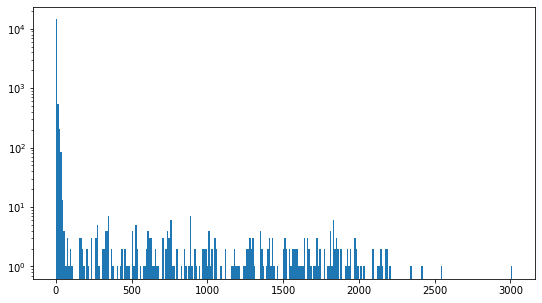

In [50]:
fig, ax = plt.subplots(figsize=(9, 5))
ax.hist([sttc.data.shape[0] for sttc in rdr.sttcs.values()], bins=300, log=True);

In [51]:
# STTC with only one count.
%timeit get_factors_from_ptc(rdr.sttcs[105771], ptc)

11.1 ms ± 83.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [52]:
%timeit get_factors_from_ptc_pinpoint(rdr.sttcs[105771], ptc)

7.93 ms ± 29.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [53]:
# STTC with 2 counts.
%timeit get_factors_from_ptc(rdr.sttcs[-175], ptc)

11.2 ms ± 67.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [54]:
%timeit get_factors_from_ptc_pinpoint(rdr.sttcs[-175], ptc)

8.09 ms ± 20.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [55]:
# STTC with 9 counts.
%timeit get_factors_from_ptc(rdr.sttcs[9360], ptc)

11.2 ms ± 23 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [56]:
%timeit get_factors_from_ptc_pinpoint(rdr.sttcs[9360], ptc)

9.31 ms ± 24.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [57]:
# STTC with 35 counts.
%timeit get_factors_from_ptc(rdr.sttcs[906551], ptc)

11.2 ms ± 53.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [58]:
%timeit get_factors_from_ptc_pinpoint(rdr.sttcs[906551], ptc)

13.5 ms ± 37.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


So since we've figured both of these algos out, might as well just which from the pinpoint to the multiple join method at around 100 counts.

In [73]:
def get_ptc_match_table(sttc, ptc):
    if sttc.data.shape[0] >= 50:
        ptc_match = get_factors_from_ptc(sttc, ptc)
        fix_factors_from_ptc(ptc_match, sttc, ptc)
    else:
        ptc_match = get_factors_from_ptc_pinpoint(sttc, ptc)
    return ptc_match

get_ptc_match_table(rdr.sttcs[906551], ptc)

,Year,Date,Daily Count,Day of Week,Month,Closest Year,D_ijd,DoM_ijd
0,2006,2006-06-06,15316.0,1,6,2011,0.845896,0.926422
1,2006,2006-06-07,15589.0,2,6,2011,0.838732,0.918576
2,2006,2006-06-08,15771.0,3,6,2011,0.820567,0.898682
3,2007,2007-06-19,14283.0,1,6,2011,0.845896,0.926422
4,2007,2007-06-20,14362.0,2,6,2011,0.838732,0.918576
5,2008,2008-06-03,10795.0,1,6,2011,0.845896,0.926422
6,2008,2008-06-04,12701.0,2,6,2011,0.838732,0.918576
7,2008,2008-06-05,11647.0,3,6,2011,0.820567,0.898682
8,2009,2009-06-16,11867.0,1,6,2011,0.845896,0.926422
9,2009,2009-06-17,12837.0,2,6,2011,0.838732,0.918576


### MSE estimator

Bagheri recommends averaging over all possible estimates of `MADT_pj`, and their Eqn. 3 looks like we should be summing over ALL daily counts to estimate AADT.  For our `ptc_match`, this would look like:

In [59]:
wanted_year = 2019
# Eqn. 3 Bagheri.
aadt_est = (ptc_match['Daily Count'] * ptc_match['D_ijd'] *
            ptc.growth_factor**(wanted_year - ptc_match['Year'])).mean()
# Eqn. 1 Bagheri.
ptc_match['MADT_est'] = (ptc_match['Daily Count'] * ptc_match['DoM_ijd'] *
                         ptc.growth_factor**(wanted_year - ptc_match['Year']))
madt_est = pd.DataFrame({'MADT_estimate': ptc_match.groupby('Month')['MADT_est'].mean()})
madt_est['AADT_est'] = aadt_est

Compare against the most recent AADT and MADT year in PTC - we can scale them to the wanted year, but that's just multiplying both by the product of the growth rate.

In [71]:
madt_est['MF_STTC'] = madt_est['MADT_estimate'] / madt_est['AADT_est']
ptc_closest_year = get_closest_year(wanted_year, ptc.data['AADT'].index.values)
madt_est['MF_PTC'] = (ptc.data['MADT'].loc[ptc_closest_year, 'MADT'] /
                      ptc.data['AADT'].loc[ptc_closest_year, 'AADT'])
mse = np.mean((madt_est['MF_STTC'] - madt_est['MF_PTC'])**2)

In [72]:
mse

0.0020389834738898153

In [166]:
import sys

def estimate_mse(sttc, ptc, wanted_year):
    ptc_match = get_ptc_match_table(sttc, ptc)
    
    ptc_match['MADT_est'] = (ptc_match['Daily Count'] * ptc_match['DoM_ijd'] *
                             ptc.growth_factor**(wanted_year - ptc_match['Year']))
    madt_est = pd.DataFrame({'MADT_estimate': ptc_match.groupby('Month')['MADT_est'].mean()})
    madt_est['AADT_est'] = (ptc_match['Daily Count'] * ptc_match['D_ijd'] *
                            ptc.growth_factor**(wanted_year - ptc_match['Year'])).mean()
    madt_est['MF_STTC'] = madt_est['MADT_estimate'] / madt_est['AADT_est']

    ptc_closest_year = get_closest_year(wanted_year, ptc.data['AADT'].index.values)
    madt_est['MF_PTC'] = (ptc.data['MADT'].loc[ptc_closest_year, 'MADT'] /
                          ptc.data['AADT'].loc[ptc_closest_year, 'AADT'])

    mse = np.mean((madt_est['MF_STTC'] - madt_est['MF_PTC'])**2)
    if mse < sys.float_info.epsilon:
        mse = 0.
    
    return mse, ptc_match, madt_est

In [168]:
estimate_mse(rdr.sttcs[229], rdr.ptcs[5849817], 2019)[0]

0.0002815345444760109

## Put it All Together

Create a function that, for a given STTC, determines the best patch PTC and estimates AADT for a wanted year.

In [169]:
tc = rdr.sttcs[229]
wanted_year = 2019

rptcs = rdr.ptcs
neighbours, distances = nb.get_neighbours(tc.centreline_id)

In [170]:
neighbour_ptcs = [rptcs[n] for n in
                  [tc.direction * nbrs for nbrs in neighbours]
                  if n in rptcs.keys()][:5]

mses = []
for ptc in neighbour_ptcs:
    mses.append(estimate_mse(tc, ptc, wanted_year))

In [171]:
mses

[(0.000271132236083406,
     Year       Date  Daily Count  Day of Week  Month  Closest Year     D_ijd  \
  0  2006 2006-03-07        228.0            1      3          2010  0.975149   
  1  2006 2006-03-08        211.0            2      3          2010  0.931112   
  2  2006 2006-03-09        263.0            3      3          2010  0.931464   
  
      DoM_ijd    MADT_est  
  0  0.994743  220.323130  
  1  0.949822  194.687863  
  2  0.950180  242.759432  ,
         MADT_estimate    AADT_est   MF_STTC    MF_PTC
  Month                                               
  3         219.256808  214.937924  1.020094  1.003628),
 (0.0,
     Year       Date  Daily Count  Day of Week  Month  Closest Year     D_ijd  \
  0  2006 2006-03-07        228.0            1      3          2010  0.965430   
  1  2006 2006-03-08        211.0            2      3          2010  0.926210   
  2  2006 2006-03-09        263.0            3      3          2010  0.939903   
  
      DoM_ijd    MADT_est  
  0  0.

There's a reason why all the errors are zero.  This comparison is between an STTC with 3 counts all in March, and a PTC with only one year's worth of data.

$$
\mathrm{MADT}_{pj} = \left\langle\mathrm{STTC}_{dij} \times \mathrm{DoM}_{dij} \times \prod_{k=i}^p GR_k\right\rangle
$$

$$
\mathrm{AADTprelim}_p = \frac{\sum \mathrm{STTC}_{dij} \times D_{dij} \times \prod_{k=i}^p GR_k}{n}
$$

Since

$$
\mathrm{DoM}_{dij}=\mathrm{MADT}_{ij}\frac{n_{d,j}}{\sum_{k=1}^{n_{d,j}}\mathrm{DT}_{d,k}}
$$

$$
\mathrm{D}_{dij}=\mathrm{AADT}_{i}\frac{n_{d,j}}{\sum_{k=1}^{n_{d,j}}\mathrm{DT}_{d,k}}
$$

We get:

$$
\frac{\mathrm{MADT}_{pj}}{\mathrm{AADTprelim}_p} = \frac{\mathrm{MADT}_{ij}}{\mathrm{AADT}_{i}}\frac{\sum \mathrm{STTC}_{dij} \times \frac{n_{d,j}}{\sum_{k=1}^{n_{d,j}}\mathrm{DT}_{d,k}} \times \prod_{k=i}^p GR_k}{\sum \mathrm{STTC}_{dij} \times \frac{n_{d,j}}{\sum_{k=1}^{n_{d,j}}\mathrm{DT}_{d,k}} \times \prod_{k=i}^p GR_k}
$$

Which means

$$
\frac{\mathrm{MADT}_{pj}}{\mathrm{AADTprelim}_p} = \mathrm{MF(STTC)}_{pj} = \mathrm{MF(PTC)}_{pj}
$$

This means that the mean square error calculator will always be 0 between the STTC and PTC.  This argument is broken either if there are multiple months or multiple years of STTC data, in which case we can't simply pull out a single value of $\mathrm{MADT}_{ij}$ from $\mathrm{DoM}_{dij}$ like in the derivation above, or if there are multiple years of PTC data and $\mathrm{DoM}_{dij}$ and $\mathrm{D}_{dij}$ aren't calculated from the same year as $\mathrm{MF(PTC)}_{pj}$ (which is not guaranteed).

In the case where the STTC only has one month's worth of data and all nearby PTCs only have one year, every MSE will be 0.  This is not a problem, since the algo will just pick the closest station.  However, if some stations have non-zero error while others have 0, the nearest zero-error PTC will be picked.  This biases the algorithm toward picking PTCs with less data.

One thing that my algorithm inherits from TEPs is that $\mathrm{MF(STTC)}_{pj}$ is estimated from the same PTC as  as $\mathrm{MF(PTC)}_{pj}$.  This is not the case in Bagheri, where the nearest PTC from the same road class is used.  This would parly resolve the problem above - there would be at most one station with 0 MSE.  If it is picked, it is at least the nearest PTC of the same road class.

Not sure quite how to fix this.  Maybe we should just test the different algos to see if one minimizes the validation error?

Anyway, for now our task is to have a minimum working example of this algorithm working.

In [184]:
# Get the minimum MSE PTC.
mmse_ptc_match = min(mses, key=lambda x: x[0])[1]

In [189]:
closest_year = get_closest_year(wanted_year, mmse_ptc_match['Year'].unique())
ptc_match_cy = ptc_match.loc[ptc_match['Year'] == closest_year, :]
aadt_est_closest_year = (ptc_match_cy['Daily Count'] * ptc_match_cy['D_ijd'] *
                         ptc.growth_factor**(wanted_year - ptc_match_cy['Year'])).mean()
aadt_est_closest_year

264.0685320292674

And that's our final answer.

In [211]:
def aadt_estimator_for_sttcs(tcs, rptcs, wanted_year):

    for tc in tcs.values():
        # Find nearest neighbours in same direction.
        neighbours, distances = nb.get_neighbours(tc.centreline_id)
        neighbour_ptcs = [rptcs[n] for n in
                          [tc.direction * nbrs for nbrs in neighbours]
                          if n in rptcs.keys()][:5]
        
        # Determine minimum MSE count of five closest neighbouring PTCs.
        mses = []
        for ptc in neighbour_ptcs:
            mses.append(estimate_mse(tc, ptc, wanted_year))
        mmse_ptc_match = min(mses, key=lambda x: x[0])[1]
    
        # Estimate AADT using most recent year of STTC counts and
        # MADT pattern of closest PTC.
        closest_year = get_closest_year(
            wanted_year, mmse_ptc_match['Year'].unique())
        ptc_match_cy = ptc_match.loc[
            ptc_match['Year'] == closest_year, :]
        aadt_est_closest_year = (
            ptc_match_cy['Daily Count'] * ptc_match_cy['D_ijd'] *
            ptc.growth_factor**(wanted_year - ptc_match_cy['Year'])).mean()

        tc.aadt_estimate = aadt_est_closest_year

In [210]:
%time aadt_estimator_for_sttcs(rdr.sttcs, rdr.ptcs, 2019)

AttributeError: 'list' object has no attribute 'values'

Handling PTCs is straightforward.

In [212]:
def aadt_estimator_for_ptcs(rptcs, wanted_year):  
    for tc in rptcs.values():
        closest_year = get_closest_year(
            wanted_year, tc.data['AADT'].index.values)
        tc.aadt_estimate = (
            tc.data['AADT'].loc[closest_year, 'AADT'] *
            tc.growth_factor**(wanted_year - closest_year))

In [213]:
%time aadt_estimator_for_ptcs(rdr.ptcs, 2019)

CPU times: user 15.3 ms, sys: 27 µs, total: 15.3 ms
Wall time: 12.3 ms
